# Cell processing, clustering and annotation from CellSeg output

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
from scipy.sparse import csr_matrix

In [2]:
dat = pd.read_csv("../../Data/CellSeg_input/output/quantifications/K2_reg1_statistics_growth5_comp.csv", index_col=0)
dat.head()

Reg  Tile Row  Tile Col  Tile Z   In-Tile Y    In-Tile X  Absolute Y  \
Cell                                                                         
1.0   0.0       1.0       1.0     0.0  306.308370  2200.022026  306.308370   
2.0   0.0       1.0       1.0     0.0  311.327586  2274.448276  311.327586   
3.0   0.0       1.0       1.0     0.0  296.294574  2254.937984  296.294574   
4.0   0.0       1.0       1.0     0.0  332.265306  2250.081633  332.265306   
5.0   0.0       1.0       1.0     0.0  311.048780  2255.278746  311.048780   

       Absolute X  Cell Size       DAPI  ...     CD45RA  Mac2Gal3        CD4  \
Cell                                     ...                                   
1.0   2200.022026      441.0  50.464803  ...   5.848314  1.400612   3.043059   
2.0   2274.448276      201.0  32.360999  ...  10.033194  2.421684   6.459609   
3.0   2254.937984      225.0  47.340674  ...   5.572685  1.349440   3.184644   
4.0   2250.081633      231.0   7.727273  ...  11.445887  2.809524   5.454545   
5.0   2255.278746      496.0  62.410726  ...  12.127969  3.558548  11.743769   

      Granzyme B      CD21       CD3e       CD15       CD34      CD31  \
Cell                                                                    
1.0     3.102866  1.059469   1.132205  16.291954   7.793198  1.098864   
2.0     3.094107  1.236291   3.282771  30.032768   8.502765  2.079108   
3.0    13.131598  0.361199   0.000000  13.222895   6.521473  0.389336   
4.0     9.134199  2.922078   5.203463  45.922078  10.458874  1.528139   
5.0    23.509667  2.781860  11.914706  15.995876  13.319438  2.066027   

       Vimentin  
Cell             
1.0    4.515139  
2.0   40.989230  
3.0   12.485814  
4.0   27.121212  
5.0   21.082664  

[5 rows x 53 columns]

In [3]:
# need to drop BCL-6--artifacts
dat.drop(columns=['BCL-6'], inplace=True)

In [4]:
dat.index = dat.index.map(str)

(array([3.3645e+04, 3.8984e+04, 9.9180e+03, 9.2000e+02, 8.4000e+01,
        1.7000e+01, 1.1000e+01, 4.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([  40. ,  277.7,  515.4,  753.1,  990.8, 1228.5, 1466.2, 1703.9,
        1941.6, 2179.3, 2417. ]),
 <BarContainer object of 10 artists>)

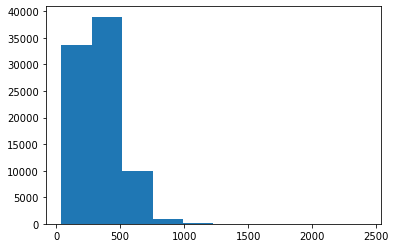

In [5]:
plt.hist(dat['Cell Size'])

In [6]:
np.where(dat.columns=="DAPI")

(array([9]),)

In [7]:
counts = csr_matrix(np.array(dat.iloc[:,9:]))

In [8]:
adata = ad.AnnData(counts)

In [9]:
adata.obs_names = dat.index
adata.var_names = list(dat.columns[9:])

In [10]:
adata.obs = dat.iloc[:,0:9]

In [11]:
adata

AnnData object with n_obs × n_vars = 83587 × 43
    obs: 'Reg', 'Tile Row', 'Tile Col', 'Tile Z', 'In-Tile Y', 'In-Tile X', 'Absolute Y', 'Absolute X', 'Cell Size'

## Now doing the processing

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


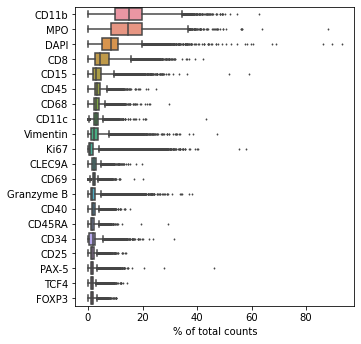

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [13]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


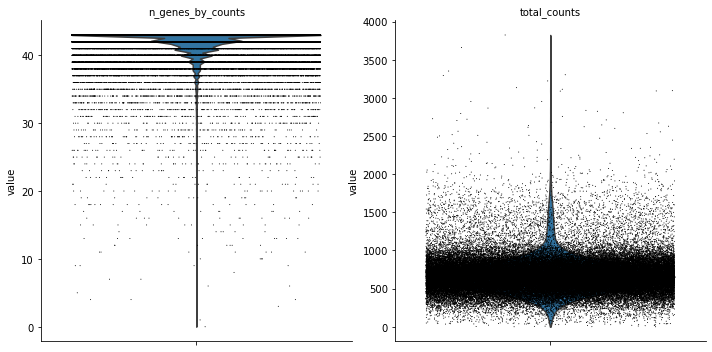

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [15]:
adata = adata[adata.obs.n_genes_by_counts > 20, :]
adata = adata[adata.obs.total_counts < 2000, :]

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
adata.raw = adata

In [18]:
sc.pp.scale(adata)

In [19]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [23]:
sc.tl.leiden(adata, resolution = 0.5)

IOStream.flush timed out


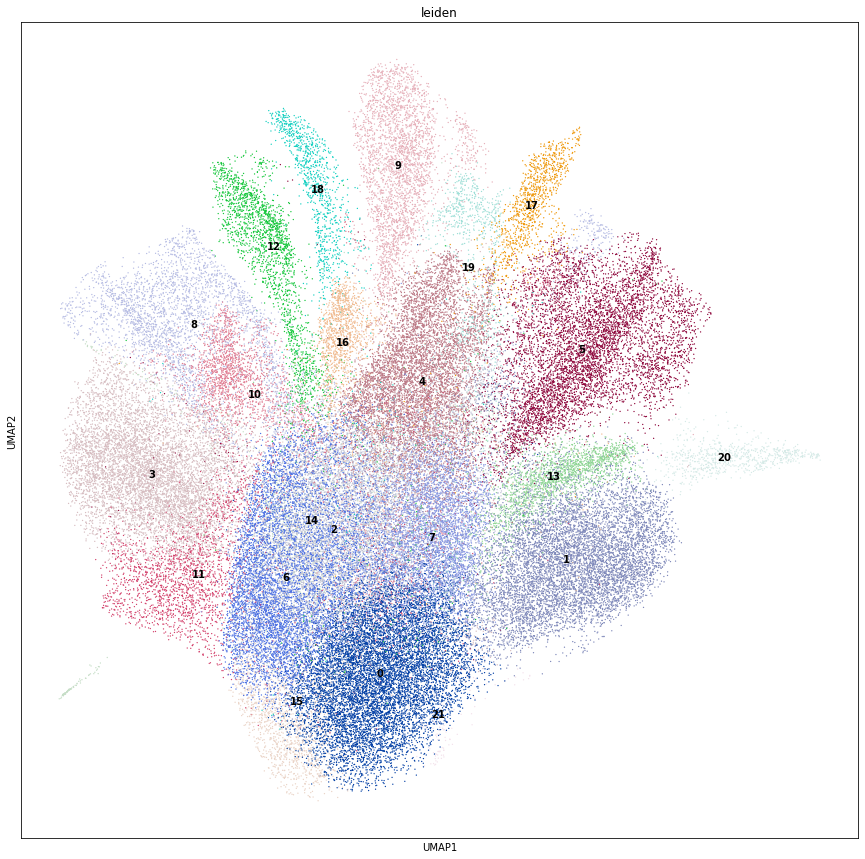

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata, color='leiden', ax=ax, size = 7, legend_loc='on data')
plt.show()

In [38]:
adata.write("../../outs/K2_region1_CellSeg_cluster-checkpoint.h5ad")

In [2]:
adata = sc.read('../../outs/R1_region1_CellSeg_cluster-checkpoint-mod1.h5ad')

## Identifying clusters
\* more likely
- 0, Neutrophil
- 1, CD8_T_Cell
- 2, 
- 3, CD8_T_Cell
- 4, Macrophage
- 5, B_Cell / FDC
- 6, Neutrophil
- 7, 
- 8, Plasma_Cell
- 9, pDC
- 10, CD4_T_Cell
- 11, 
- 12, B_Cell
- 13, CD4_T_Cell
- 14, Macrophage_M2
- 15, Neutrophil
- 16, 
- 17, cDC2 / endothelial
- 18, FDC / Lymphatics
- 19, cDC1
- 20, cDC2
- 21, Neutrophil

missing vasculature

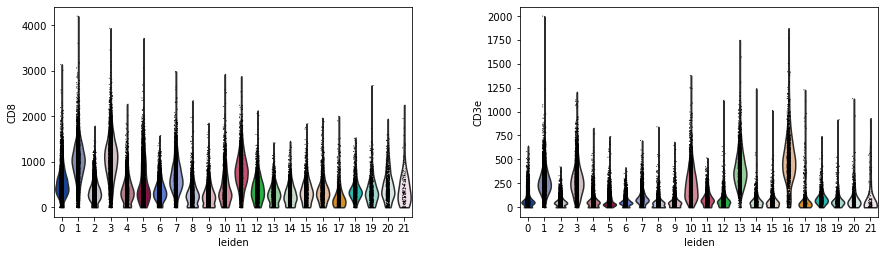

In [4]:
# CD8 t cell
sc.pl.violin(adata, ['CD8', 'CD3e'], groupby='leiden')

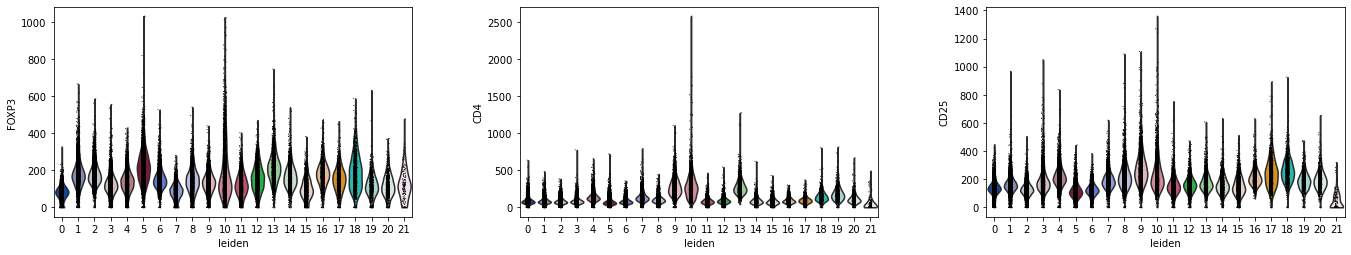

In [39]:
# CD4 t cell, Treg
# sc.pl.violin(adata, ['CD3e', 'CD4', 'PD-1'], groupby='leiden')
sc.pl.violin(adata, ['FOXP3', 'CD4', 'CD25'], groupby='leiden')

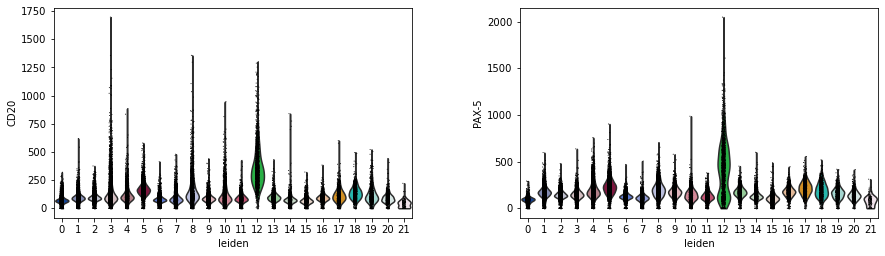

In [23]:
# B Cells
sc.pl.violin(adata, ['CD20', 'PAX-5'], groupby='leiden')
# sc.pl.violin(adata, ['PAX-5', 'BCL-2', 'Ki67'], groupby='leiden')

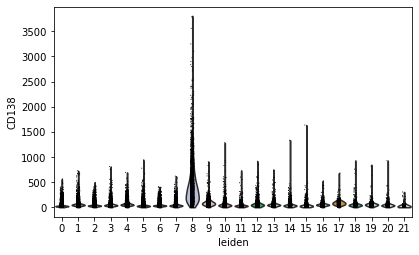

In [24]:
# Plasma cells
sc.pl.violin(adata, ['CD138'], groupby='leiden')

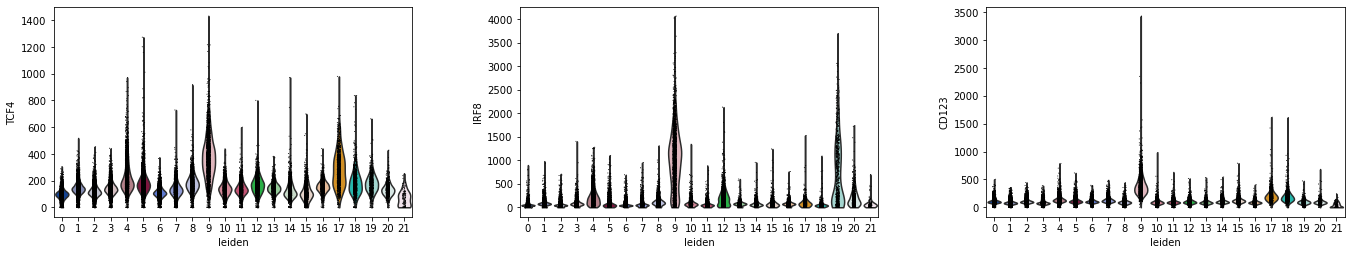

In [25]:
# pDCs
sc.pl.violin(adata, ['TCF4', 'IRF8', 'CD123'], groupby='leiden')

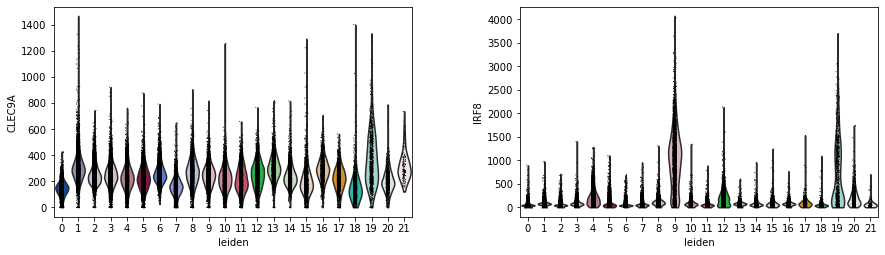

In [26]:
# cDC1
sc.pl.violin(adata, ['CLEC9A', 'IRF8'], groupby='leiden')

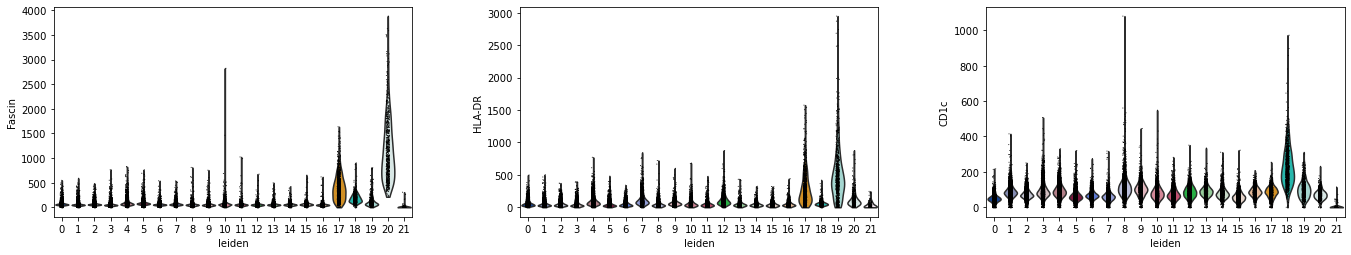

In [27]:
# cDC2
sc.pl.violin(adata, ['Fascin', 'HLA-DR', 'CD1c'], groupby='leiden')

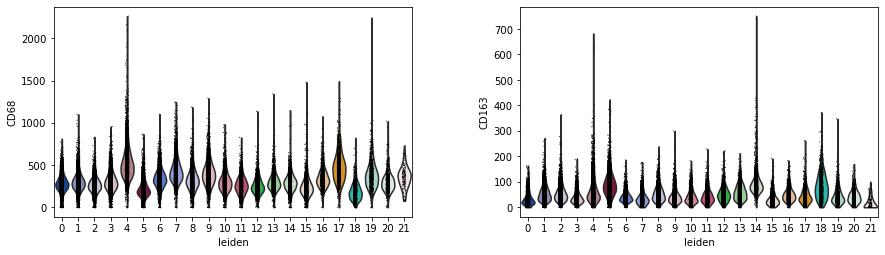

In [28]:
# macrophage
sc.pl.violin(adata, ['CD68', 'CD163'], groupby='leiden')

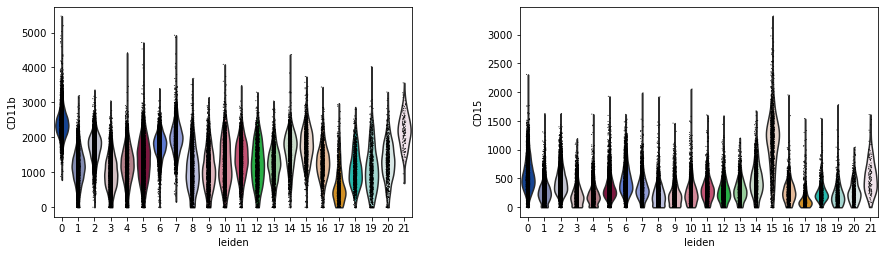

In [29]:
# Neutrophil
sc.pl.violin(adata, ['CD11b', 'CD15'], groupby='leiden')

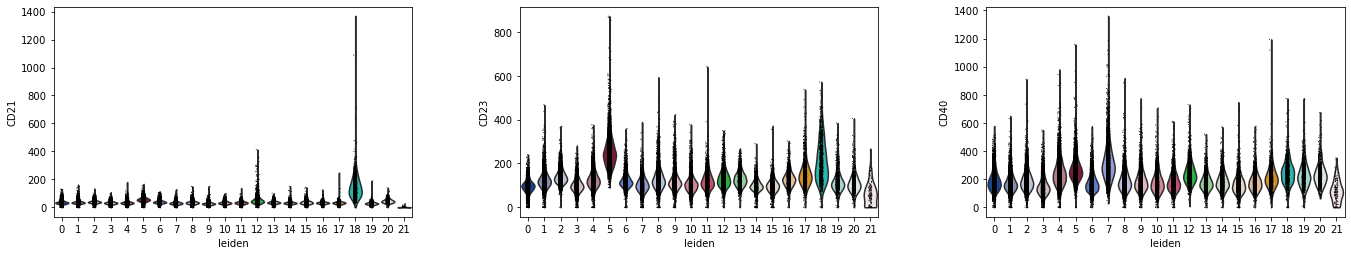

In [30]:
# fDC
sc.pl.violin(adata, ['CD21', 'CD23', 'CD40'], groupby='leiden')

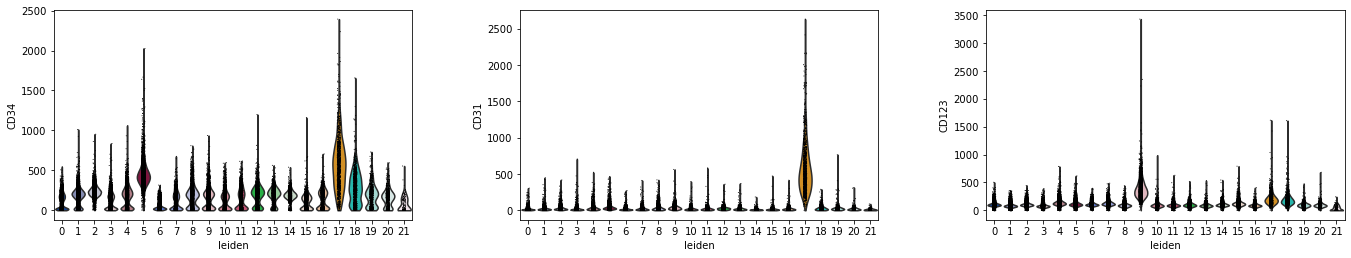

In [31]:
# Vasculature
sc.pl.violin(adata, ['CD34', 'CD31', 'CD123'], groupby='leiden')

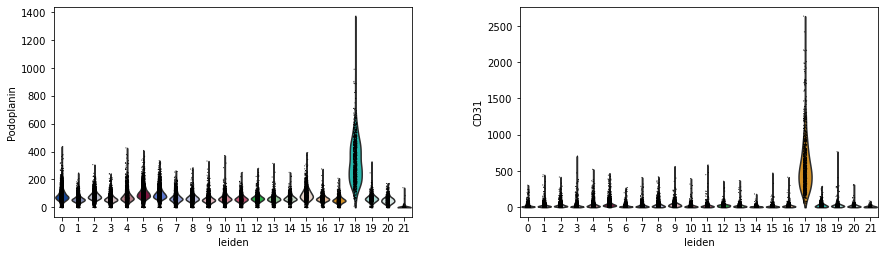

In [32]:
# Lymphatics
sc.pl.violin(adata, ['Podoplanin', 'CD31'], groupby='leiden')

In [33]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:3

In [61]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0:5, 0:10]

0       1      2           3         4     5           6       7  \
0       CD11b   BCL-2   CD34        Ki67      CD68  CD34         MPO   CD11b   
1         MPO  CD45RA    MPO         CD8  Mac2Gal3  CD23       CD11b    CD40   
2        CD15     CD8   DAPI        CD3e      PD-1   CD5        CD30    CD68   
3        CD45    CD3e  CD11b        PD-1     CD11c  CD69  Podoplanin    CD45   
4  Podoplanin     CD5  FOXP3  Granzyme B      CD25  CD21        CD15  HLA-DR   

       8      9  
0   IRF4  CD123  
1  CD138   IRF8  
2   Ki67   TCF4  
3  CD11c    CD4  
4   CD1c   CD25

In [60]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0:5, 10:]

10          11      12     13     14          15     16      17  \
0    CD4  Granzyme B    CD20    CD4  CD163        CD15   CD3e    CD31   
1   ICOS         CD8  CD45RA   CD3e   CD30         MPO   CD69    CD34   
2  CD134        CD45   PAX-5  BCL-2    MPO       CD11b   CD45  Fascin   
3   CD3e        DAPI   BCL-2    CD5  CD11c        CD10  BCL-2    TCF4   
4   Ki67        Ki67  HLA-DR   DAPI   DAPI  Podoplanin   DAPI  HLA-DR   

           18      19      20      21  
0  Podoplanin  HLA-DR  Fascin   CD11b  
1        CD1c    IRF8    CD21     MPO  
2        PD-1     CD4  HLA-DR    DAPI  
3        CD21  CLEC9A    CD40  CLEC9A  
4      Fascin   CD11c    IRF8    CD15

### More fine-grained annotation
- 0, Neutrophil
- 1, Neutrophil
- 2, Neutrophil
- 3, Neutrophil
- 4, 
- 5, Macrophage
- 6, B_Cell
- 7, B_Cell
- 8, cDC1
- 9, 
- 10, Lymphatics
- 11, Endothelial
- 12, Endothelial

In [3]:
# doing more fine-grained annotation
adata_sub = adata[adata.obs['leiden'].isin(('2', '7', '5', '11', '16', '17', '18')), :]

In [4]:
sc.tl.pca(adata_sub, svd_solver='arpack')

In [5]:
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub)

In [57]:
# sc.tl.leiden(adata_sub, resolution=0.75)

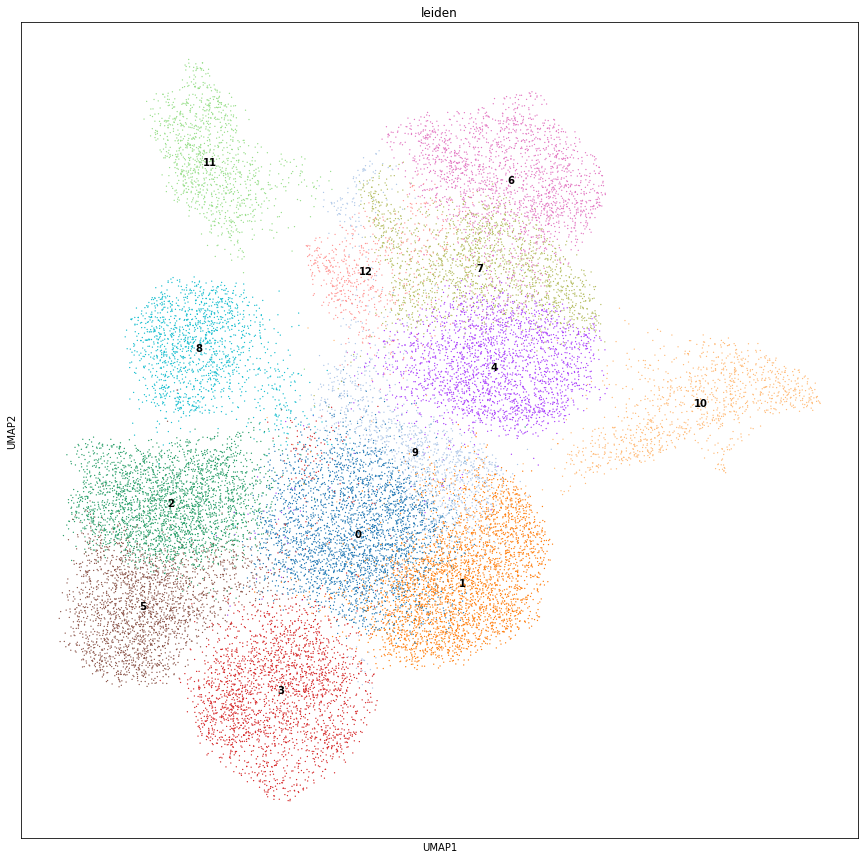

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata_sub, color='leiden', ax=ax, size = 7, legend_loc='on data')
plt.show()

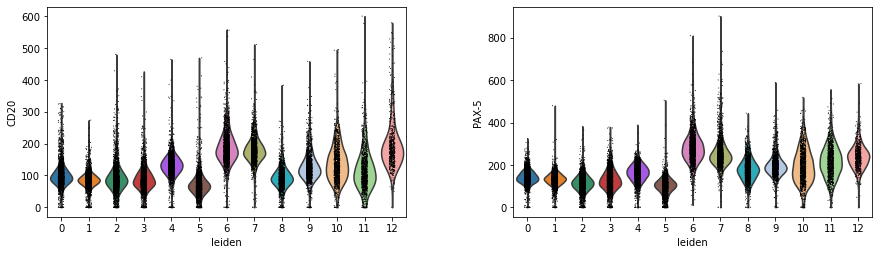

In [74]:
# B cell
sc.pl.violin(adata_sub, ['CD20', 'PAX-5'], groupby='leiden')
# sc.pl.violin(adata_sub, ['PAX-5', 'BCL-2', 'Ki67'], groupby='leiden')

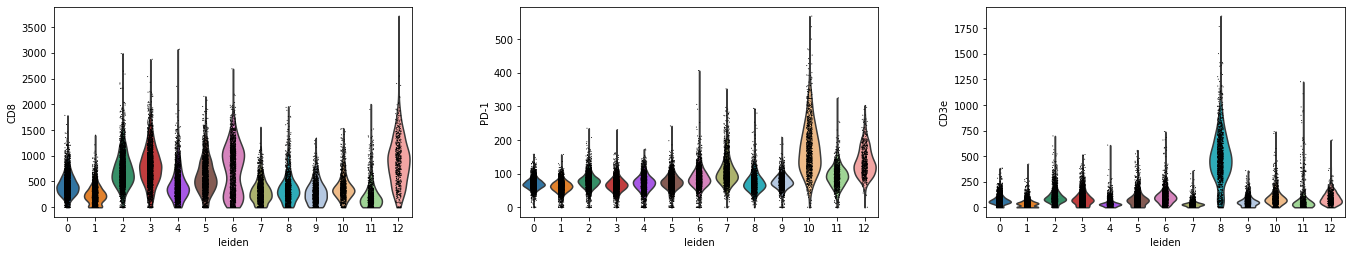

In [47]:
# T cell
sc.pl.violin(adata_sub, ['CD8', 'PD-1', 'CD3e'], groupby='leiden')

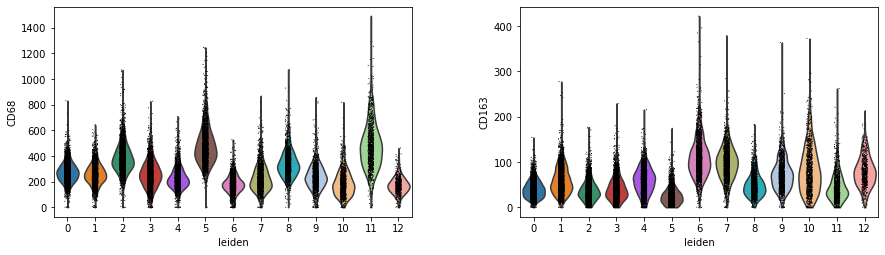

In [48]:
# macrophage
sc.pl.violin(adata_sub, ['CD68', 'CD163'], groupby='leiden')

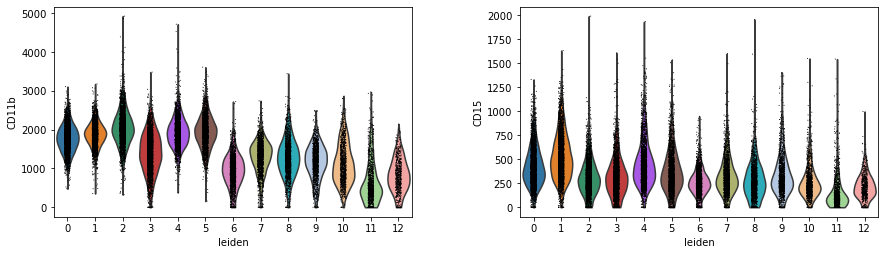

In [49]:
# Neutrophil
sc.pl.violin(adata_sub, ['CD11b', 'CD15'], groupby='leiden')

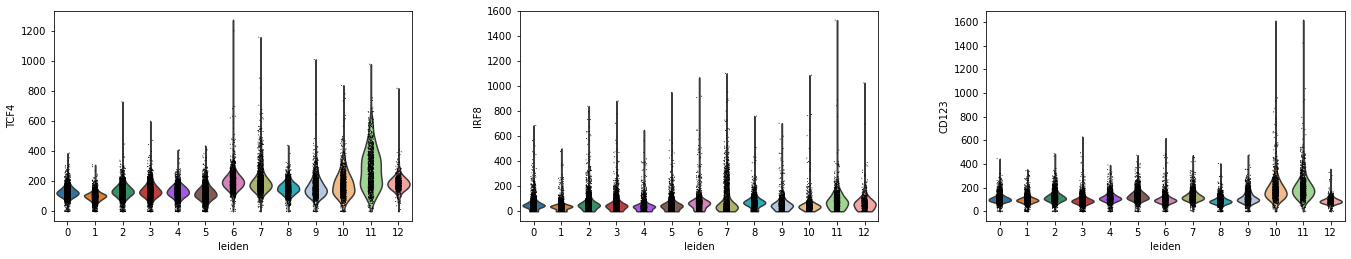

In [50]:
# pDCs
sc.pl.violin(adata_sub, ['TCF4', 'IRF8', 'CD123'], groupby='leiden')

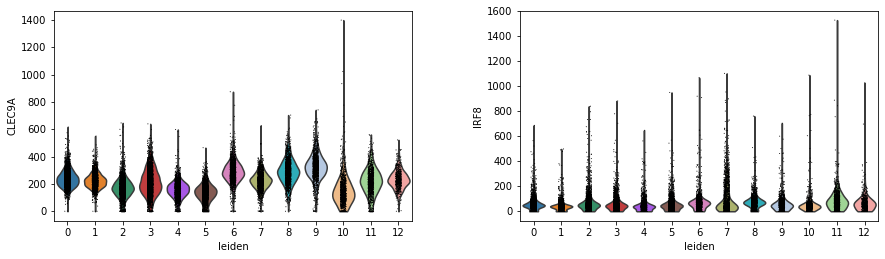

In [51]:
# cDC1
sc.pl.violin(adata_sub, ['CLEC9A', 'IRF8'], groupby='leiden')

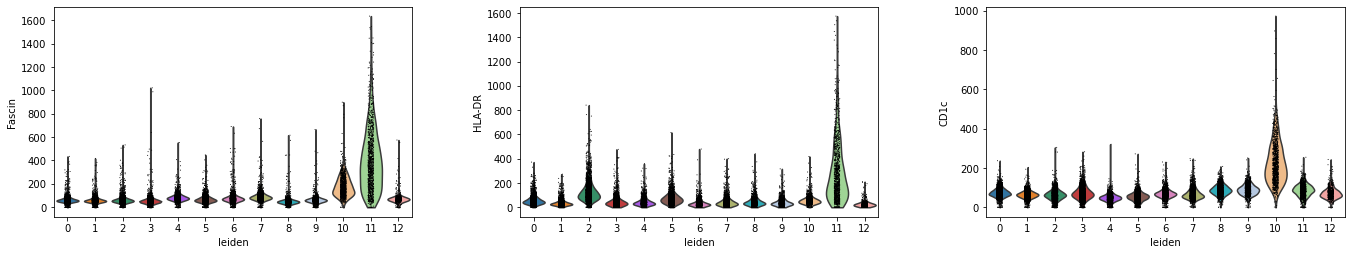

In [52]:
# cDC2
sc.pl.violin(adata_sub, ['Fascin', 'HLA-DR', 'CD1c'], groupby='leiden')

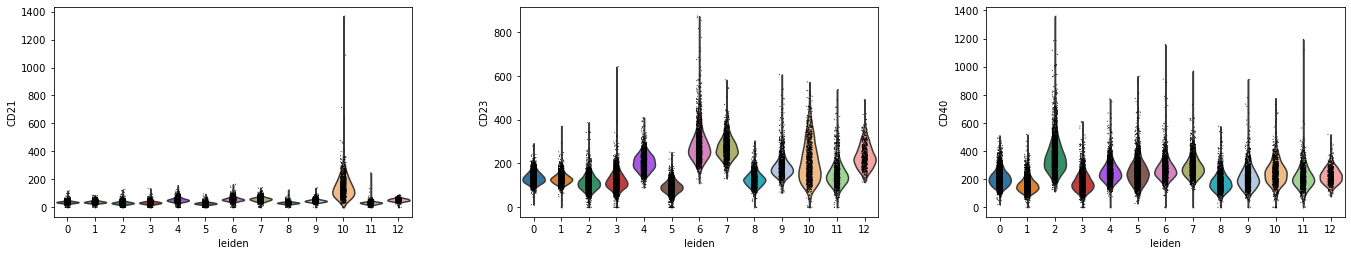

In [55]:
# fDC
sc.pl.violin(adata_sub, ['CD21', 'CD23', 'CD40'], groupby='leiden')

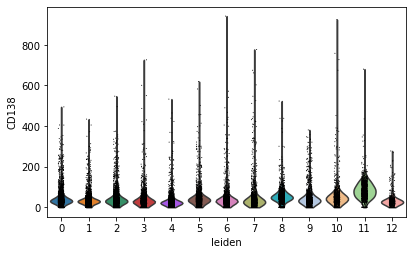

In [53]:
# Plasma cells
sc.pl.violin(adata_sub, ['CD138'], groupby='leiden')

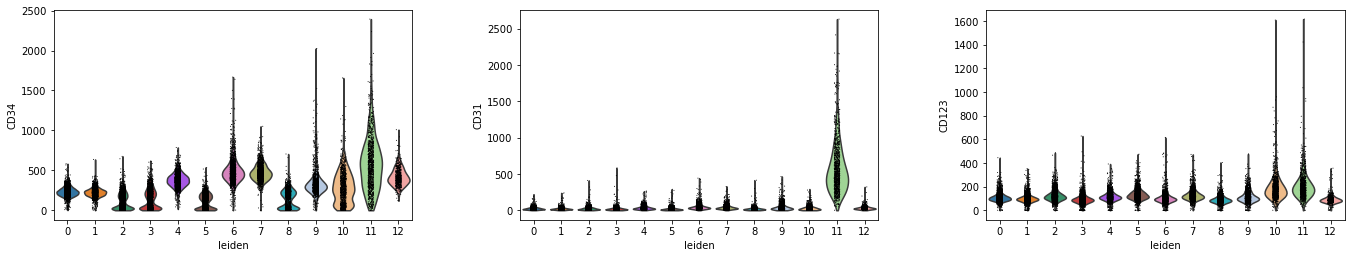

In [54]:
# Vasculature
sc.pl.violin(adata_sub, ['CD34', 'CD31', 'CD123'], groupby='leiden')

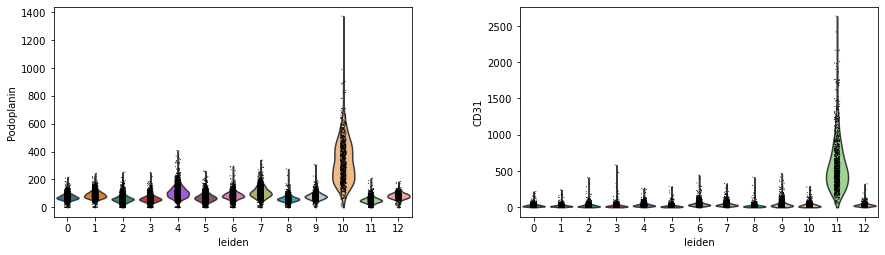

In [56]:
# Lymphatics
sc.pl.violin(adata_sub, ['Podoplanin', 'CD31'], groupby='leiden')

In [57]:
sc.tl.rank_genes_groups(adata_sub, 'leiden', method='t-test')

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [58]:
pd.DataFrame(adata_sub.uns['rank_genes_groups']['names']).head(5)

0      1      2           3      4         5       6     7      8  \
0   CD11b    MPO  CD11b  Granzyme B   CD34  Vimentin     CD5  CD23   CD3e   
1    DAPI  CD11b   CD40         CD8   CD23      CD68  CD45RA   CD5   CD45   
2     MPO   CD30   CD45        CD45  CD11b     CD11b   BCL-2  CD34   CD69   
3  CLEC9A   CD15    CD4        Ki67    MPO       MPO   PAX-5  CD20   CD25   
4    CD15   DAPI   CD68       CD11c    CD5      CD25    CD23  CD69  CD11c   

        9          10      11     12  
0    DAPI  Podoplanin    CD31   Ki67  
1   FOXP3        CD1c  Fascin   CD34  
2  CLEC9A        PD-1    CD68   CD23  
3    CD30        CD25    TCF4  PAX-5  
4   PAX-5        CD21    CD34   PD-1

### Making the annotations

In [7]:
adata.obs['cell_type'] = "unknown"

In [8]:
# From main data...
adata.obs.loc[adata.obs['leiden'].isin(('10','13')) , 'cell_type'] = "CD4_T_Cell"
# adata.obs.loc[adata.obs['leiden'] == '6' , 'cell_type'] = "Tfh"
adata.obs.loc[adata.obs['leiden'].isin(('1','3')), 'cell_type'] = "CD8_T_Cell"
adata.obs.loc[adata.obs['leiden'] == '12' , 'cell_type'] = "B_Cell"
# adata.obs.loc[adata.obs['leiden'] == '5' , 'cell_type'] = "B_Cell_germ"
# adata.obs.loc[adata.obs['leiden'] == '9' , 'cell_type'] = "Treg"
adata.obs.loc[adata.obs['leiden'] == '5' , 'cell_type'] = "FDC" 
adata.obs.loc[adata.obs['leiden'] == '18' , 'cell_type'] = "Lymphatics"
adata.obs.loc[adata.obs['leiden'] == '17' , 'cell_type'] = "Endothelial"
adata.obs.loc[adata.obs['leiden'] == '9' , 'cell_type'] = "pDC"
adata.obs.loc[adata.obs['leiden'] == '19' , 'cell_type'] = "cDC1"
adata.obs.loc[adata.obs['leiden'] == '20' , 'cell_type'] = "cDC2"
adata.obs.loc[adata.obs['leiden'] == '4' , 'cell_type'] = "Macrophage"
adata.obs.loc[adata.obs['leiden'] == '14' , 'cell_type'] = "Macrophage_M2"
adata.obs.loc[adata.obs['leiden'] == '8' , 'cell_type'] = "Plasma_Cell"
adata.obs.loc[adata.obs['leiden'].isin(('0','6','15','21')) , 'cell_type'] = "Macrophage_MPO_pos"

In [9]:
# From subset data...
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'].isin(('0','1','2'))] , 'cell_type'] = "Macrophage_MPO_pos"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '5'] , 'cell_type'] = "Macrophage"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '3'] , 'cell_type'] = "Cytotoxic_T_Cell"
# adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'].isin(('6','7'))] , 'cell_type'] = "B_Cell"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '8'] , 'cell_type'] = "cDC1"

adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '10'] , 'cell_type'] = "Lymphatics"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'].isin(('11','12'))] , 'cell_type'] = "Endothelial"


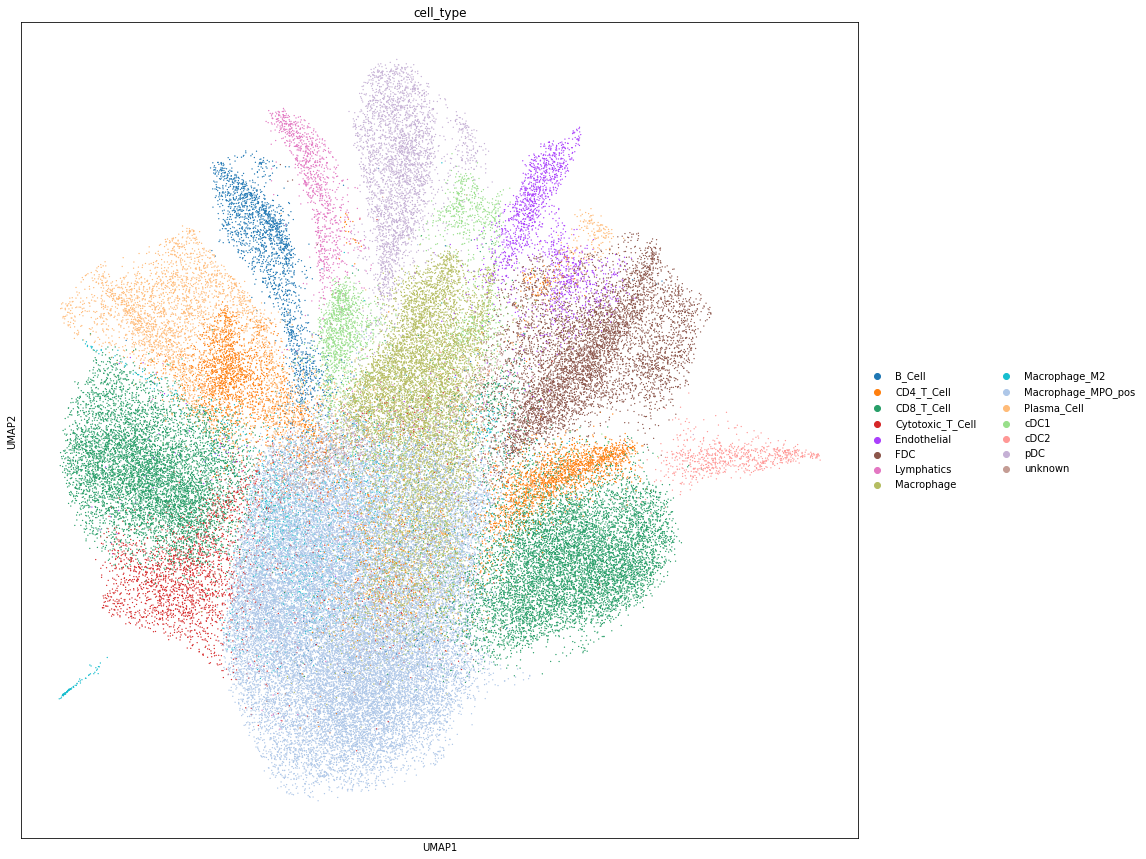

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
# sc.pl.umap(adata, color='cell_type', size=7, ax=ax, legend_loc='on data')
sc.pl.umap(adata, color='cell_type', size=7, ax=ax)
plt.show()

In [3]:
adata.obs['cell_type'].value_counts()/adata.shape[0]

Macrophage_MPO_pos    0.333465
CD8_T_Cell            0.182697
Macrophage            0.108206
FDC                   0.071645
CD4_T_Cell            0.056042
Plasma_Cell           0.043055
pDC                   0.038205
Cytotoxic_T_Cell      0.029263
cDC1                  0.029227
B_Cell                0.025614
Macrophage_M2         0.023910
Endothelial           0.020921
unknown               0.014884
Lymphatics            0.013467
cDC2                  0.009398
Name: cell_type, dtype: float64

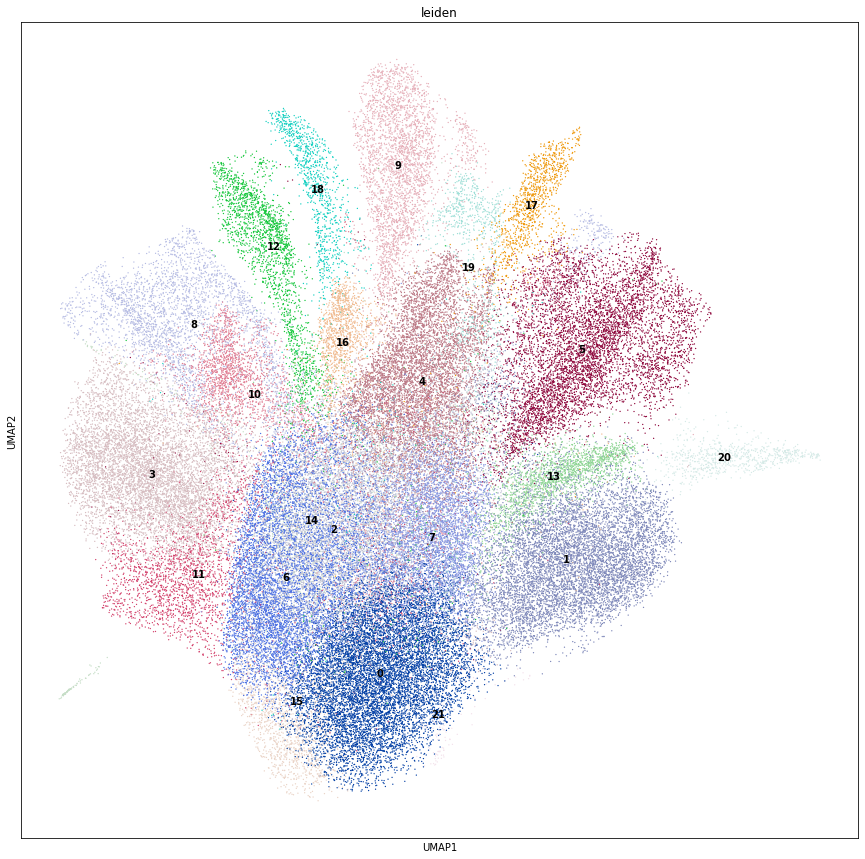

In [68]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata, color='leiden', ax=ax, size = 7, legend_loc='on data')
plt.show()

In [4]:
adata.obs.to_csv("../../outs/K2_region1_CellSeg_clusters.csv")

In [2]:
# adata.write("../../outs/K2_region1_CellSeg_cluster-checkpoint.h5ad")
adata = sc.read('../../outs/K2_region1_CellSeg_cluster-checkpoint.h5ad')

In [76]:
adata_sub.obs.to_csv("../../outs/K2_region1_CellSeg_subclusters.csv")

## Revisions
- Drop dead cells, as defined by DAPI signal
- Remove sample specific cell names

### renaming

In [2]:
adata = sc.read('../../outs/K2_region1_CellSeg_cluster-checkpoint.h5ad')

In [5]:
adata.obs.cell_type.value_counts()

Macrophage_MPO_pos    27782
CD8_T_Cell            15221
Macrophage             9015
FDC                    5969
CD4_T_Cell             4669
Plasma_Cell            3587
pDC                    3183
Cytotoxic_T_Cell       2438
cDC1                   2435
B_Cell                 2134
Macrophage_M2          1992
Endothelial            1743
unknown                1240
Lymphatics             1122
cDC2                    783
Name: cell_type, dtype: int64

In [9]:
adata.obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83313 entries, 1.0 to 83587.0
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Reg                83313 non-null  float64 
 1   Tile Row           83313 non-null  float64 
 2   Tile Col           83313 non-null  float64 
 3   Tile Z             83313 non-null  float64 
 4   In-Tile Y          83313 non-null  float64 
 5   In-Tile X          83313 non-null  float64 
 6   Absolute Y         83313 non-null  float64 
 7   Absolute X         83313 non-null  float64 
 8   Cell Size          83313 non-null  float64 
 9   n_genes_by_counts  83313 non-null  int32   
 10  total_counts       83313 non-null  float32 
 11  leiden             83313 non-null  category
 12  cell_type          83313 non-null  category
 13  new_cell_type      83313 non-null  object  
dtypes: category(2), float32(1), float64(9), int32(1), object(1)
memory usage: 9.8+ MB


In [8]:
adata.obs['new_cell_type'] = adata.obs.cell_type.astype(str)

In [10]:
adata.obs.loc[adata.obs['new_cell_type'] == 'Macrophage_MPO_pos' , 'new_cell_type'] = "Macrophage"

### Drop dead cells

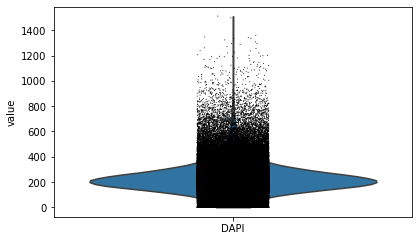

In [5]:
# sc.pl.violin(adata, ['DAPI'], groupby='new_cell_type')
# sc.pl.violin(adata, ['DAPI']) #hmmm, no obvious cut off point
sc.pl.violin(adata, ['DAPI'], use_raw=True) #hmmm, no obvious cut off point

In [4]:
# adata.write("../../outs/cleaned_ref_data/K2_v2.h5ad")
adata = sc.read("../../outs/cleaned_ref_data/HVCD1_v2.h5ad")

In [3]:
adata.obs['new_cell_type'] = adata.obs.cell_type.astype(str)

In [4]:
adata.obs.loc[adata.obs['new_cell_type'] == 'Macrophage_MPO+' , 'new_cell_type'] = "Macrophage"

In [5]:
adata.obs.new_cell_type.value_counts()

CD4_T_Cell     54914
B_Cell         40123
Macrophage     24802
CD8_T_Cell     19525
cDC1           15696
FDC            14475
pDC            11094
Endothelial    10563
cDC2            4874
Tfh             3132
Plasma_Cell     2421
Neutrophil      1991
Lymphatics      1628
unknown         1063
Mast_Cell         46
Name: new_cell_type, dtype: int64

In [6]:
adata.write("../../outs/cleaned_ref_data/HVCD1_v2.h5ad")

/mnt/isilon/cscb/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'new_cell_type' as categorical
